# CHA2DS2-VASc Stratification Analysis on STARR-OMOP
Richard Yoo (rmyoo@stanford.edu)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prework" data-toc-modified-id="Prework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prework</a></span></li><li><span><a href="#Cohort-Construction" data-toc-modified-id="Cohort-Construction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cohort Construction</a></span><ul class="toc-item"><li><span><a href="#Identify-Patients-with-Atrial-Fibrillation" data-toc-modified-id="Identify-Patients-with-Atrial-Fibrillation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify Patients with Atrial Fibrillation</a></span></li><li><span><a href="#Remove-Patients-with-Rheumatic-Heart-Disease" data-toc-modified-id="Remove-Patients-with-Rheumatic-Heart-Disease-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Remove Patients with Rheumatic Heart Disease</a></span></li><li><span><a href="#Remove-Patients-without-Race-Information" data-toc-modified-id="Remove-Patients-without-Race-Information-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Remove Patients without Race Information</a></span></li><li><span><a href="#Remove-Patients-without-Gender-Information" data-toc-modified-id="Remove-Patients-without-Gender-Information-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Remove Patients without Gender Information</a></span></li><li><span><a href="#Filter-Encounters-by-Age" data-toc-modified-id="Filter-Encounters-by-Age-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Filter Encounters by Age</a></span></li><li><span><a href="#Remove-Encounters-after-Warfarin-Prescription" data-toc-modified-id="Remove-Encounters-after-Warfarin-Prescription-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Remove Encounters after Warfarin Prescription</a></span></li></ul></li><li><span><a href="#Outcomes-Assessment" data-toc-modified-id="Outcomes-Assessment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outcomes Assessment</a></span></li><li><span><a href="#CHA2DS2-VASc-Indicators" data-toc-modified-id="CHA2DS2-VASc-Indicators-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CHA2DS2-VASc Indicators</a></span><ul class="toc-item"><li><span><a href="#CHF-History" data-toc-modified-id="CHF-History-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CHF History</a></span></li><li><span><a href="#Hypertension-History" data-toc-modified-id="Hypertension-History-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Hypertension History</a></span></li><li><span><a href="#Diabetes-Mellitus-History" data-toc-modified-id="Diabetes-Mellitus-History-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Diabetes Mellitus History</a></span></li><li><span><a href="#Vascular-Disease-History" data-toc-modified-id="Vascular-Disease-History-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Vascular Disease History</a></span></li></ul></li><li><span><a href="#Compute-CHA2DS2-VASc" data-toc-modified-id="Compute-CHA2DS2-VASc-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compute CHA2DS2-VASc</a></span></li><li><span><a href="#Obtain-Cohort-Statistics" data-toc-modified-id="Obtain-Cohort-Statistics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Obtain Cohort Statistics</a></span></li><li><span><a href="#Survival-Analysis" data-toc-modified-id="Survival-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Create-Survival-Table" data-toc-modified-id="Create-Survival-Table-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Create Survival Table</a></span></li><li><span><a href="#Study-CHA2DS2-VASc-Concordance" data-toc-modified-id="Study-CHA2DS2-VASc-Concordance-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Study CHA2DS2-VASc Concordance</a></span></li><li><span><a href="#Observe-Negative-Events" data-toc-modified-id="Observe-Negative-Events-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Observe Negative Events</a></span><ul class="toc-item"><li><span><a href="#Old-Guideline" data-toc-modified-id="Old-Guideline-7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span>Old Guideline</a></span></li><li><span><a href="#New-Guideline" data-toc-modified-id="New-Guideline-7.3.2"><span class="toc-item-num">7.3.2&nbsp;&nbsp;</span>New Guideline</a></span></li></ul></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Logistic Regression</a></span></li></ul></div>

In [1]:
import datetime
import lifelines
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import qgrid
import re
import scipy.stats as stats
import statsmodels.api as sm
import swifter
import multiprocessing

from collections import defaultdict
from dateutil.relativedelta import relativedelta
from google.cloud import bigquery
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Prework

Below project setup assumes access to STARR-OMOP identified through Nero.

In [2]:
# Project setup.
user_id = os.getlogin()
nero_gcp_project = 'som-nero-phi-nigam-starr'
project_id = 'som-nero-phi-nigam-starr'
dataset_id = 'shahlab_omop_cdm5_subset_2021_09_29'
work_project_id = nero_gcp_project

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/{}/.config/gcloud/application_default_credentials.json'.format(user_id)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

In [4]:
# Create client.
client = bigquery.Client(project=work_project_id)

/home/rmyoo/.conda/envs/rmyoo_env/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Cohort Construction

Following below cohort construction described in Gage et al.:
- Patients with ICD-9-CM code 427.31 in primary or secondary diagnosis were selected as AF cohort
- Patients with rheumatic heart disease (identified by ICD-9-CM codes 393.x~398.x) were excluded
- Patients whose ages were younger than 65 or older than 95 years were excluded
- Patients who were prescribed with warfarin at the time of hospital discharge were excluded

### Identify Patients with Atrial Fibrillation

ICD-9-CM code 427.31 maps to OMOP concept ID [313217](https://athena.ohdsi.org/search-terms/terms/313217).

In [5]:
af_concept_id = "313217"

In [6]:
query = """ 
SELECT 
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  condition_concept_id IN ({af_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'af_concept_id': af_concept_id})

af_condition_result = client.query(query).to_dataframe()
af_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,60648942,3296242,313217,2016-06-15,2016-06-15 00:00:00,None,NaT,32020,None,163119.0,87616746.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":311972108,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
1,75726414,3101531,313217,2017-05-22,2017-05-22 00:00:00,None,NaT,32020,None,163119.0,102224436.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":314604199,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
2,131209494,3362686,313217,2020-02-03,2020-02-03 00:00:00,None,NaT,32020,None,150332.0,150981711.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":322465804,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
3,127449715,3921015,313217,2019-12-04,2019-12-04 00:00:00,None,NaT,32020,None,185331.0,147963519.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":322186540,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
4,88596656,1952380,313217,2018-02-09,2018-02-09 00:00:00,None,NaT,32020,None,NaN,114531441.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":316790553,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821844,1480243,456836,313217,2009-09-25,2009-09-25 06:05:00,None,NaT,32019,None,NaN,36400864.0,NaN,427.31,44821957,None,0,"{""hsp_account_id"":50042745,""dx_id"":5107}",None,shc_hsp_acct_admit_dx
821845,49832313,2910047,313217,2015-09-20,2015-09-20 00:00:00,None,NaT,32019,None,174205.0,76553097.0,NaN,427.31,44821957,None,0,"{""tx_id"":4232699}",None,lpch_arpb_transactions
821846,42392638,293301,313217,2015-03-12,2015-03-12 00:00:00,None,NaT,32019,None,162345.0,70689166.0,NaN,427.31,44821957,None,0,"{""tx_id"":2235395}",None,lpch_arpb_transactions
821847,147790471,4088136,313217,2020-11-12,2020-11-12 13:50:00,None,NaT,32019,None,NaN,167244605.0,NaN,I48.91,45576876,None,0,"{""hsp_account_id"":73161331,""dx_id"":732531}",None,lpch_hsp_acct_admit_dx


### Remove Patients with Rheumatic Heart Disease

Extract all ICD-9-CM codes from 393.x~398.x, chronic rheumatic heart disease.

In [7]:
rhd_source_concept_code = """
"393",
"394", 
       "394.0",
       "394.1",
       "394.2",
       "394.9",
"395", 
       "395.0",
       "395.1",
       "395.2",
       "395.9",
"396", 
       "396.0", 
       "396.1", 
       "396.2", 
       "396.3", 
       "396.8", 
       "396.9",
"397", 
       "397.0", 
       "397.1", 
       "397.9",
"398", 
       "398.0", 
       "398.9", 
                 "398.90", 
                 "398.91",
                 "398.99"
"""

In [8]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({rhd_source_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'rhd_source_concept_code': rhd_source_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44833554,Diseases of tricuspid valve,Condition,ICD9CM,4-dig billing code,None,397.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44828968,Mitral valve stenosis and aortic valve insuffi...,Condition,ICD9CM,4-dig billing code,None,396.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44837097,Rheumatic mitral insufficiency,Condition,ICD9CM,4-dig billing code,None,394.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44828969,Multiple involvement of mitral and aortic valves,Condition,ICD9CM,4-dig billing code,None,396.8,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44827777,Mitral valve insufficiency and aortic valve st...,Condition,ICD9CM,4-dig billing code,None,396.2,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44831226,Diseases of mitral valve,Condition,ICD9CM,3-dig nonbill code,None,394,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44832363,Mitral stenosis,Condition,ICD9CM,4-dig billing code,None,394.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44820852,Other and unspecified rheumatic aortic diseases,Condition,ICD9CM,4-dig billing code,None,395.9,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44824234,Rheumatic myocarditis,Condition,ICD9CM,4-dig billing code,None,398.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44819690,Mitral valve stenosis and aortic valve stenosis,Condition,ICD9CM,4-dig billing code,None,396.0,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [9]:
rhd_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [10]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({rhd_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'rhd_source_concept_id': rhd_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44820854,317296,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44832363,315273,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
2,44820855,4169568,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
3,44826633,4108659,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
4,44831226,319843,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
5,44831227,314368,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
6,44824234,320743,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44819691,320416,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44828969,320416,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
9,44832364,320416,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN


In [11]:
rhd_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

Retrieve people with rheumatic heart disease.

In [12]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  condition_concept_id IN ({rhd_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'rhd_concept_id': rhd_concept_id})

rhd_condition_result = client.query(query).to_dataframe()
rhd_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,36216999,3384554,314054,2014-09-21,2014-09-21 00:00:00,None,NaT,32020,None,175408.0,65231786.0,NaN,424.1,44820866,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":308058361,""line"":3}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
1,41339724,3293953,315273,2015-02-13,2015-02-13 00:00:00,None,NaT,32020,None,179680.0,69794815.0,NaN,394.0,44832363,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":308911104,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
2,60105082,3048135,315282,2016-06-02,2016-06-02 00:00:00,None,NaT,32020,None,174141.0,87092104.0,NaN,I06.9,35207652,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":310892413,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
3,49852106,3830645,314054,2015-09-21,2015-09-21 00:00:00,None,NaT,32020,None,165455.0,77275211.0,NaN,424.1,44820866,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":310462587,""line"":3}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
4,32616770,2547204,314054,2014-06-02,2014-06-02 00:00:00,None,NaT,32020,None,155976.0,62102362.0,NaN,424.1,44820866,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":307202149,""line"":2}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356756,144572364,3286288,314054,2020-09-25,2020-09-25 06:34:00,None,NaT,32019,None,NaN,164433591.0,NaN,I35.8,45581772,None,0,"{""hsp_account_id"":73157057,""dx_id"":730177}",None,lpch_hsp_acct_admit_dx
356757,42323326,3523964,314054,2015-03-11,2015-03-11 13:00:00,None,NaT,32019,None,NaN,70680150.0,NaN,424.1,44820866,None,0,"{""hsp_account_id"":70383426,""dx_id"":5063}",None,lpch_hsp_acct_admit_dx
356758,144561398,3286288,314054,2020-09-25,2020-09-25 06:34:00,None,NaT,32019,None,NaN,164433591.0,NaN,I35.8,37084574,None,0,"{""hsp_account_id"":73157057,""dx_id"":730177}",None,lpch_hsp_acct_admit_dx
356759,138689941,3244492,439834,2020-06-23,2020-06-23 12:45:00,None,NaT,32019,None,NaN,159392845.0,NaN,I06.1,1413643,None,0,"{""hsp_account_id"":73009265,""dx_id"":655533}",None,lpch_hsp_acct_admit_dx


Double check top 10 conditions.

In [13]:
top10_index = rhd_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'314054, 319843, 316993, 315273, 320416, 319825, 313221, 4108659, 314368, 318776'

In [14]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,315273,Mitral valve stenosis
1,316993,Tricuspid valve disorder
2,313221,Rheumatic aortic stenosis
3,319843,Mitral valve disorder
4,320416,Diseases of mitral and aortic valves
5,314054,Aortic valve disorder
6,4108659,Mitral and aortic incompetence
7,319825,Rheumatic heart disease
8,318776,Rheumatic mitral regurgitation
9,314368,Mitral stenosis with insufficiency


Remove those patients with rheumatic heart disease from the cohort.

In [15]:
af_condition_result = af_condition_result[~af_condition_result['person_id'].isin(rhd_condition_result['person_id'])]
af_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,60648942,3296242,313217,2016-06-15,2016-06-15 00:00:00,None,NaT,32020,None,163119.0,87616746.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":311972108,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
1,75726414,3101531,313217,2017-05-22,2017-05-22 00:00:00,None,NaT,32020,None,163119.0,102224436.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":314604199,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
2,131209494,3362686,313217,2020-02-03,2020-02-03 00:00:00,None,NaT,32020,None,150332.0,150981711.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":322465804,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
3,127449715,3921015,313217,2019-12-04,2019-12-04 00:00:00,None,NaT,32020,None,185331.0,147963519.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":322186540,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
5,84701332,3425510,313217,2017-11-22,2017-11-22 00:00:00,None,NaT,32020,None,155976.0,110526814.0,NaN,I48.91,45576876,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":315894413,""line"":1}",condition.rule.2.lpch_hsp_admit_diag,lpch_hsp_admit_diag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821840,147577884,520868,313217,2020-11-10,2020-11-10 08:52:00,None,NaT,32019,None,NaN,166637402.0,NaN,I48.91,45576876,None,0,"{""hsp_account_id"":50000516093,""dx_id"":1371452}",None,shc_hsp_acct_admit_dx
821842,85841470,1157278,313217,2017-12-15,2017-12-15 14:27:00,None,NaT,32019,None,NaN,111487578.0,NaN,I48.91,45576876,None,0,"{""hsp_account_id"":61467850,""dx_id"":1371452}",None,shc_hsp_acct_admit_dx
821843,144961846,600931,313217,2020-10-01,2020-10-01 11:31:00,None,NaT,32019,None,NaN,164837298.0,NaN,I48.91,45576876,None,0,"{""hsp_account_id"":50000097397,""dx_id"":1371452}",None,shc_hsp_acct_admit_dx
821847,147790471,4088136,313217,2020-11-12,2020-11-12 13:50:00,None,NaT,32019,None,NaN,167244605.0,NaN,I48.91,45576876,None,0,"{""hsp_account_id"":73161331,""dx_id"":732531}",None,lpch_hsp_acct_admit_dx


### Remove Patients without Race Information

In [16]:
cohort_list = ", ".join(af_condition_result['person_id'].unique().astype(str))

In [17]:
query = """ 
SELECT 
  person_id, gender_concept_id, birth_DATETIME, ethnicity_concept_id, race_concept_id
FROM
  `{project_id}.{dataset_id}.person`
WHERE
  person_id IN ({cohort_list})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list})

demography_result = client.query(query).to_dataframe()
demography_result

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id,race_concept_id
0,844511,0,1950-07-04,0,0
1,2190044,0,1977-10-21,38003564,2000039205
2,169482,0,1926-01-02,38003564,8527
3,353393,0,1936-12-27,38003564,2000039205
4,958538,0,1953-10-09,38003564,8515
...,...,...,...,...,...
52919,417308,8507,1939-11-15,38003564,8527
52920,151698,8507,1925-08-07,38003564,8527
52921,3254637,8507,2000-05-27,38003564,8516
52922,529745,8507,1942-08-03,38003564,8527


In [18]:
# Normalize hispanic ethnicity.
demography_result.loc[demography_result['ethnicity_concept_id'] == 38003563, 'race_concept_id'] = 38003563

In [19]:
demography_result.groupby('race_concept_id').count()

,person_id,gender_concept_id,birth_DATETIME,ethnicity_concept_id
race_concept_id,,,,
0,355,355,355,355
8515,6044,6044,6044,6044
8516,2187,2187,2187,2187
8527,33662,33662,33662,33662
8557,462,462,462,462
8657,122,122,122,122
38003563,3890,3890,3890,3890
2000039205,3103,3103,3103,3103
2000039210,730,730,730,730


In [20]:
# Join.
af_condition_result = pd.merge(af_condition_result,
                               demography_result[['person_id', 'gender_concept_id', 'birth_DATETIME', 'race_concept_id']],
                               on='person_id', how='left')

In [21]:
race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    8557: 'Pacific Islander', 
    8657: 'Native American', 
    38003563: 'Hispanic'
}

In [22]:
# Drop entries with 'race_concept_id' not in race_map.
af_condition_result = af_condition_result[af_condition_result['race_concept_id'].isin(race_map.keys())]

In [23]:
af_condition_result.groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id,gender_concept_id,birth_DATETIME
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,64583,64583,64583,64583,64583,3173,3173,64583,0,45384,...,0,64583,64583,5488,64583,64583,36462,64583,64583,64583
8516,18082,18082,18082,18082,18082,1030,1030,18082,0,13823,...,0,18082,18082,1728,18082,18082,10651,18082,18082,18082
8527,339949,339949,339949,339949,339949,18201,18201,339949,0,245647,...,0,339949,339949,32121,339949,339949,191058,339949,339949,339949
8557,4233,4233,4233,4233,4233,222,222,4233,0,2802,...,0,4233,4233,472,4233,4233,2261,4233,4233,4233
8657,1181,1181,1181,1181,1181,63,63,1181,0,938,...,0,1181,1181,95,1181,1181,759,1181,1181,1181
38003563,33051,33051,33051,33051,33051,1868,1868,33051,0,22882,...,0,33051,33051,3692,33051,33051,18159,33051,33051,33051


### Remove Patients without Gender Information

In [24]:
gender_map = {
    8532: 'Female', 
    8507: 'Male', 
}

In [25]:
# Drop entries with 'gender_concept_id' not in gender_map.
af_condition_result = af_condition_result[af_condition_result['gender_concept_id'].isin(gender_map.keys())]

In [26]:
af_condition_result.groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id,birth_DATETIME,race_concept_id
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,283119,283119,283119,283119,283119,14352,14352,283119,0,203580,...,0,283119,283119,26133,283119,283119,159338,283119,283119,283119
8532,177948,177948,177948,177948,177948,10201,10201,177948,0,127890,...,0,177948,177948,17459,177948,177948,100002,177948,177948,177948


### Filter Encounters by Age

In [27]:
def compute_age(condition_start_DATE, birth_DATETIME):
    return relativedelta(condition_start_DATE, birth_DATETIME).years

af_condition_result['age_years'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: compute_age(row['condition_start_DATE'], row['birth_DATETIME']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [28]:
def age_65_to_95(age_years):    
    age_lower_end = 65
    age_upper_end = 95

    if age_lower_end <= age_years and age_years <= age_upper_end:
        return True
    return False

select_mask = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: age_65_to_95(row['age_years']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [29]:
select_mask.value_counts()

True     336831
False    124236
dtype: int64

In [30]:
# Drop encounters outside age range [65, 95].
af_condition_result = af_condition_result[select_mask]

### Remove Encounters after Warfarin Prescription

In [31]:
query="""
SELECT
  * 
FROM
  `{project_id}.{dataset_id}.concept` 
WHERE
  vocabulary_id = 'RxNorm' AND
  standard_concept = 'S' AND
  lower(concept_name) LIKE '%warfarin%'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,40163518,warfarin sodium 10 MG Oral Tablet,Drug,RxNorm,Clinical Drug,S,855296,2009-08-02,2099-12-31,None,athena_vocab,NaN
1,40163516,warfarin sodium 1 MG [Narfarin],Drug,RxNorm,Branded Drug Comp,S,855293,2009-08-02,2099-12-31,None,athena_vocab,NaN
2,40163542,warfarin sodium 3 MG Oral Tablet [Jantoven],Drug,RxNorm,Branded Drug,S,855322,2009-08-02,2099-12-31,None,athena_vocab,NaN
3,40163543,warfarin sodium 3 MG [Coumadin],Drug,RxNorm,Branded Drug Comp,S,855319,2009-08-02,2099-12-31,None,athena_vocab,NaN
4,40163547,warfarin sodium 4 MG Oral Tablet [Coumadin],Drug,RxNorm,Branded Drug,S,855326,2009-08-02,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
67,40121983,warfarin Oral Tablet [Marfarin],Drug,RxNorm,Branded Drug Form,S,540228,2005-09-11,2099-12-31,None,athena_vocab,NaN
68,40163517,warfarin sodium 10 MG,Drug,RxNorm,Clinical Drug Comp,S,855295,2009-08-02,2099-12-31,None,athena_vocab,NaN
69,1310149,warfarin,Drug,RxNorm,Ingredient,S,11289,1970-01-01,2099-12-31,None,athena_vocab,NaN
70,40163564,warfarin sodium 6 MG [Jantoven],Drug,RxNorm,Branded Drug Comp,S,855341,2009-08-02,2099-12-31,None,athena_vocab,NaN


In [32]:
warfarin_concept_id = ", ".join(result["concept_id"].unique().astype(str))

In [33]:
# Query all RxNorm that has warfarin as an ingredient.
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({warfarin_concept_id}) AND
  relationship_id = 'RxNorm ing of'  
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'warfarin_concept_id': warfarin_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,1310149,21154555,RxNorm ing of,2015-08-17,2099-12-31,None,athena_vocab,NaN
1,1310149,21164383,RxNorm ing of,2015-08-17,2099-12-31,None,athena_vocab,NaN
2,1310149,21056316,RxNorm ing of,2015-08-17,2099-12-31,None,athena_vocab,NaN
3,1310149,21036670,RxNorm ing of,2015-08-17,2099-12-31,None,athena_vocab,NaN
4,1310149,44042640,RxNorm ing of,2017-06-25,2099-12-31,None,athena_vocab,NaN
5,1310149,40163539,RxNorm ing of,2009-08-03,2099-12-31,None,athena_vocab,NaN
6,1310149,40163559,RxNorm ing of,2009-08-03,2099-12-31,None,athena_vocab,NaN
7,1310149,40163507,RxNorm ing of,2009-08-03,2099-12-31,None,athena_vocab,NaN
8,1310149,21076074,RxNorm ing of,2015-08-17,2099-12-31,None,athena_vocab,NaN
9,1310149,40163529,RxNorm ing of,2009-08-03,2099-12-31,None,athena_vocab,NaN


In [34]:
contains_warfarin_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

In [35]:
# Query all brand name warfarin.
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_2 IN ({warfarin_concept_id}) AND
  relationship_id = 'Brand name of'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'warfarin_concept_id': warfarin_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,19042260,40163541,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN
1,2021229,1310149,Brand name of,2020-07-31,2099-12-31,None,athena_vocab,NaN
2,44021617,1310149,Brand name of,2017-06-25,2099-12-31,None,athena_vocab,NaN
3,19042260,1310149,Brand name of,2006-01-20,2099-12-31,None,athena_vocab,NaN
4,19070242,40121983,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...
57,19046532,40163548,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN
58,19046532,40163556,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN
59,19046532,40163551,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN
60,19046532,40163526,Brand name of,2016-10-07,2099-12-31,None,athena_vocab,NaN


In [36]:
brand_warfarin_concept_id = ", ".join(result["concept_id_1"].unique().astype(str))

In [37]:
warfarin_concept_id = warfarin_concept_id + ", " + contains_warfarin_concept_id + ", " + brand_warfarin_concept_id

In [38]:
cohort_list = ", ".join(af_condition_result['person_id'].unique().astype(str))

In [39]:
query="""
SELECT
  * 
FROM
  `{project_id}.{dataset_id}.drug_exposure` 
WHERE
  person_id IN ({cohort_list}) AND
  drug_concept_id IN ({warfarin_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'warfarin_concept_id': warfarin_concept_id})

warfarin_result = client.query(query).to_dataframe()
warfarin_result

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_DATE,drug_exposure_start_DATETIME,drug_exposure_end_DATE,drug_exposure_end_DATETIME,verbatim_end_DATE,drug_type_concept_id,stop_reason,...,provider_id,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,trace_id,unit_id,load_table_id
0,153371829,69682,40163554,2017-06-28,2017-06-28 00:00:00,2017-06-28,2017-06-28 00:00:00,2017-06-28,38000177,Reorder,...,185475.0,103888527.0,NaN,855332,40163554,None,None,"{""order_med_id"":528983615}",drug.rule.1.shc_order_med,shc_order_med
1,251958074,4137133,1310149,2020-09-12,2020-09-12 12:49:00,2020-09-13,2020-09-13 11:07:00,2020-09-13,38000177,None,...,258196.0,163498322.0,NaN,540493,2000058566,Not Applicable,Each,"{""order_med_id"":681367281}",drug.rule.1.shc_order_med,shc_order_med
2,143901975,891218,1310149,2017-02-15,2017-02-15 14:32:00,2017-02-15,2017-02-15 14:53:00,2017-02-15,38000177,None,...,258038.0,97964868.0,NaN,540493,2000058566,Not Applicable,Each,"{""order_med_id"":517210044}",drug.rule.1.shc_order_med,shc_order_med
3,193810890,480667,1310149,2018-11-30,2018-11-30 07:19:00,2018-12-04,2018-12-04 15:14:00,2018-12-04,38000177,Patient Discharge,...,269125.0,127843289.0,NaN,540493,2000058566,Not Applicable,Each,"{""order_med_id"":584370292}",drug.rule.1.shc_order_med,shc_order_med
4,76997494,274520,40163534,2014-05-08,2014-05-08 00:00:00,2014-06-13,2014-06-13 00:00:00,2014-06-13,38000177,Reorder,...,258297.0,61493436.0,NaN,855312,40163534,None,None,"{""order_med_id"":439048810}",drug.rule.1.shc_order_med,shc_order_med
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118408,199914933,408070,40163554,2019-02-10,2019-02-10 17:52:00,2019-02-10,2019-02-10 17:52:00,2019-02-10,38000180,None,...,212380.0,129237837.0,NaN,855332,40163554,None,None,"{""order_med_id"":592251780}",drug.rule.2.shc_f_ip_hsp_sum_med_admin,shc_f_ip_hsp_sum_med_admin
118409,80641025,196227,40163524,2014-07-09,2014-07-09 17:38:00,2014-07-09,2014-07-09 17:38:00,2014-07-09,38000180,Patient Discharge,...,258002.0,62950197.0,NaN,855302,40163524,None,None,"{""order_med_id"":442549478}",drug.rule.2.shc_f_ip_hsp_sum_med_admin,shc_f_ip_hsp_sum_med_admin
118410,115399677,206714,40163554,2015-12-31,2015-12-31 16:14:00,2015-12-31,2015-12-31 16:14:00,2015-12-31,38000180,None,...,236187.0,80879764.0,NaN,855332,40163554,None,None,"{""order_med_id"":481974381}",drug.rule.2.shc_f_ip_hsp_sum_med_admin,shc_f_ip_hsp_sum_med_admin
118411,62262307,143342,40163540,2013-06-13,2013-06-13 18:00:00,2013-06-13,2013-06-13 18:00:00,2013-06-13,38000180,Patient Discharge,...,280990.0,54384749.0,NaN,855318,40163540,None,None,"{""order_med_id"":420969251}",drug.rule.2.shc_f_ip_hsp_sum_med_admin,shc_f_ip_hsp_sum_med_admin


In [40]:
def encounter_before_warfarin(person_id, condition_start_DATE):    
    match = warfarin_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if condition_start_DATE >= row['drug_exposure_start_DATE']:
                return False
    return True

select_mask = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: encounter_before_warfarin(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [41]:
select_mask.value_counts()

True     233129
False    103702
dtype: int64

In [42]:
# Drop encounters that happened after Warfarin prescription.
af_condition_result = af_condition_result[select_mask]

Redefine cohort.

In [43]:
cohort_list = ", ".join(af_condition_result['person_id'].unique().astype(str))

## Outcomes Assessment

In Gage et al., authors use ICD-9-CM codes 434 (occlusion of cerebral arteries), 435 (transient cerebral ischemia), and 436 (acute, but ill-defined, cerebrovascular disease) as ischemic stroke events.

Extract all concept codes from 434, 435, and 436.

In [44]:
stroke_source_concept_code = """
"434", "434.0", "434.1", "434.9",
"435", "435.0", "435.1", "435.2", "435.3", "435.8", "435.9",
"436"
"""

In [45]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({stroke_source_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'stroke_source_concept_code': stroke_source_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44834738,Vertebrobasilar artery syndrome,Condition,ICD9CM,4-dig billing code,None,435.3,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44819715,Vertebral artery syndrome,Condition,ICD9CM,4-dig billing code,None,435.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44820875,Transient cerebral ischemia,Condition,ICD9CM,3-dig nonbill code,None,435,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44832386,Basilar artery syndrome,Condition,ICD9CM,4-dig billing code,None,435.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44832385,Cerebral thrombosis,Condition,ICD9CM,4-dig nonbill code,None,434.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44835951,Cerebral embolism,Condition,ICD9CM,4-dig nonbill code,None,434.1,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44835952,"Acute, but ill-defined, cerebrovascular disease",Condition,ICD9CM,3-dig billing code,None,436,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44819716,Unspecified transient cerebral ischemia,Condition,ICD9CM,4-dig billing code,None,435.9,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44824253,Occlusion of cerebral arteries,Condition,ICD9CM,3-dig nonbill code,None,434,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44827801,Subclavian steal syndrome,Condition,ICD9CM,4-dig billing code,None,435.2,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [46]:
stroke_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [47]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({stroke_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'stroke_source_concept_id': stroke_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44827801,433505,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44834738,376714,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44820875,373503,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
3,44819716,373503,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44835952,374060,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
5,44832387,373503,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44819715,434656,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44824253,372924,Maps to,2014-07-01,2099-12-31,None,athena_vocab,NaN
8,44832385,441874,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44835951,375557,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN


In [48]:
stroke_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

Retrieve patients with stroke outcome.

In [49]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({stroke_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'stroke_concept_id': stroke_concept_id})

stroke_outcome_result = client.query(query).to_dataframe()
stroke_outcome_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,71105237,266617,373503,2017-02-15,2017-02-15 00:00:00,None,NaT,32020,None,187244.0,97971256.0,NaN,G45.8,35207398,None,0,"{""pat_enc_csn_id"":131214872114,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,64232741,344316,373503,2016-09-10,2016-09-10 00:00:00,None,NaT,32020,None,NaN,91156038.0,NaN,G45.9,35207399,None,0,"{""pat_enc_csn_id"":131195662513,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,13414519,254884,373503,2012-01-08,2012-01-08 00:00:00,None,NaT,32020,None,NaN,46050702.0,NaN,435.9,44819716,None,0,"{""pat_enc_csn_id"":131014893734,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,110377969,447780,373503,2019-03-04,2019-03-04 00:00:00,None,NaT,32020,None,233302.0,132303337.0,NaN,G45.9,35207399,None,0,"{""pat_enc_csn_id"":131261476002,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,129382957,540030,373503,2020-01-07,2020-01-07 00:00:00,None,NaT,32020,None,271875.0,149550193.0,NaN,G45.9,35207399,None,0,"{""pat_enc_csn_id"":131278594940,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11886,115096387,598769,373503,2019-05-17,2019-05-17 09:43:00,None,NaT,32019,None,NaN,NaN,NaN,G45.9,1411728,None,0,"{""hsp_account_id"":40236343,""dx_id"":1364582}",None,shc_hsp_acct_admit_dx
11887,131312359,453686,373503,2020-02-04,2020-02-04 13:40:00,None,NaT,32019,None,NaN,151019852.0,NaN,G45.9,45542892,None,0,"{""hsp_account_id"":40378854,""dx_id"":1364582}",None,shc_hsp_acct_admit_dx
11888,111863225,447780,373503,2019-03-27,2019-03-27 13:57:00,None,NaT,32019,None,NaN,133607480.0,NaN,G45.9,1411728,None,0,"{""hsp_account_id"":40208983,""dx_id"":1364582}",None,shc_hsp_acct_admit_dx
11889,158695190,511605,373503,2021-04-26,2021-04-26 11:46:00,None,NaT,32019,None,NaN,177902087.0,NaN,G45.9,37083454,None,0,"{""hsp_account_id"":50002480478,""dx_id"":1364582}",None,shc_hsp_acct_admit_dx


Double check top 10 conditions.

In [50]:
top10_index = stroke_outcome_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'373503, 374060, 372924, 374055, 433505, 375557, 376714, 434656, 441874'

In [51]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,433505,Subclavian steal syndrome
1,441874,Cerebral thrombosis
2,376714,Vertebrobasilar artery syndrome
3,373503,Transient cerebral ischemia
4,374060,Acute ill-defined cerebrovascular disease
5,374055,Basilar artery syndrome
6,375557,Cerebral embolism
7,372924,Cerebral artery occlusion
8,434656,Vertebral artery syndrome


## CHA2DS2-VASc Indicators

### CHF History

Gage et al. uses ICD-9-CM codes 398.91, 402.01, 402.11, 402.91, 428.x, and 518.4 as indicators for congestive heart failure.

In [52]:
chf_source_concept_code = """
"398.91",
"402.01",
"402.11",
"402.91",
"428", "428.0", 
       "428.1", 
       "428.2", "428.20", "428.21", "428.22", "428.23",
       "428.3", "428.30", "428.31", "428.32", "428.33",
       "428.4", "428.40", "428.41", "428.42", "428.43",
       "428.9",
"518.4"
"""

In [53]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({chf_source_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'chf_source_concept_code': chf_source_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44823119,Acute on chronic combined systolic and diastol...,Condition,ICD9CM,5-dig billing code,None,428.43,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44830086,"Systolic heart failure, unspecified",Condition,ICD9CM,5-dig billing code,None,428.20,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44834732,Systolic heart failure,Condition,ICD9CM,4-dig nonbill code,None,428.2,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44824251,Acute diastolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.31,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44823108,Rheumatic heart failure (congestive),Condition,ICD9CM,5-dig billing code,None,398.91,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44833573,Acute on chronic systolic heart failure,Condition,ICD9CM,5-dig billing code,None,428.23,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44833557,Malignant hypertensive heart disease with hear...,Condition,ICD9CM,5-dig billing code,None,402.01,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44831249,Diastolic heart failure,Condition,ICD9CM,4-dig nonbill code,None,428.3,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44820870,Chronic combined systolic and diastolic heart ...,Condition,ICD9CM,5-dig billing code,None,428.42,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44831230,Unspecified hypertensive heart disease with he...,Condition,ICD9CM,5-dig billing code,None,402.91,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [54]:
chf_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [55]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({chf_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'chf_source_concept_id': chf_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44832381,40482727,Maps to,2014-07-01,2099-12-31,None,athena_vocab,NaN
1,44831250,443587,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44827796,316139,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44823119,44782733,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
4,44820869,40480603,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
5,44827794,439846,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44830086,443580,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44824251,40481042,Maps to,2013-10-01,2099-12-31,None,athena_vocab,NaN
8,44831230,314378,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
9,44826642,319835,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN


In [56]:
chf_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

Retrieve people with congestive heart failure.

In [57]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({chf_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'chf_concept_id': chf_concept_id})

chf_condition_result = client.query(query).to_dataframe()
chf_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,38578746,404552,40480603,2014-11-25,2014-11-25 00:00:00,None,NaT,32020,None,233791.0,67322741.0,NaN,428.21,44820869,None,0,"{""pat_enc_csn_id"":131059966624,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,113018737,398970,261600,2019-04-15,2019-04-15 00:00:00,None,NaT,32020,None,NaN,134596416.0,NaN,J81.0,45538482,None,0,"{""pat_enc_csn_id"":131264468346,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,39938534,442304,44782718,2015-01-08,2015-01-08 00:00:00,None,NaT,32020,None,236125.0,68568453.0,NaN,428.41,44827795,None,0,"{""pat_enc_csn_id"":131063538863,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,28145708,75059,314378,2013-12-09,2013-12-09 00:00:00,None,NaT,32020,None,187624.0,57958232.0,NaN,402.91,44831230,None,0,"{""pat_enc_csn_id"":131026520864,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,42872809,365561,314378,2015-03-24,2015-03-24 00:00:00,None,NaT,32020,None,271153.0,71088610.0,NaN,402.91,44831230,None,0,"{""pat_enc_csn_id"":131077381716,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186509,102645258,840889,40481042,2018-10-21,2018-10-21 21:31:00,None,NaT,32019,None,NaN,125985156.0,NaN,I50.31,45548022,Yes,4203942,"{""hsp_account_id"":63336633,""dx_id"":1347850}",None,shc_hsp_acct_dx_list
186510,62245172,261598,319835,2016-07-25,2016-07-25 12:47:00,None,NaT,32019,None,NaN,89159309.0,NaN,I50.31,45548022,None,0,"{""hsp_account_id"":58615330,""dx_id"":1347850}",None,shc_hsp_acct_dx_list
186511,98951584,496700,319835,2018-08-17,2018-08-17 19:58:00,None,NaT,32019,None,NaN,122713017.0,NaN,I50.31,45548022,Yes,4203942,"{""hsp_account_id"":62964134,""dx_id"":1347850}",None,shc_hsp_acct_dx_list
186512,84854542,214671,319835,2017-11-28,2017-11-28 12:55:00,None,NaT,32019,None,NaN,110671811.0,NaN,I50.31,45548022,None,0,"{""hsp_account_id"":60513861,""dx_id"":1347850}",None,shc_hsp_acct_dx_list


Use index hospitalization as 'recent' CHF.

In [58]:
chf_condition_result = chf_condition_result.sort_values(by=['person_id', 'condition_start_DATE']).groupby('person_id').head(1)
chf_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
6197,12805,22572,319835,2001-07-25,2001-07-25 00:00:00,None,NaT,32020,None,238354.0,10214458.0,NaN,1035077,2000006502,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":3732964,""line"":8}",condition.rule.2.shc_hsp_admit_diag,shc_hsp_admit_diag
65480,194810,35835,319835,2008-01-23,2008-01-23 00:00:00,None,NaT,32020,None,211994.0,27537649.0,NaN,428.0,44826642,Admitting diagnosis,4203942,"{""pat_enc_csn_id"":5012431,""line"":7}",condition.rule.2.shc_hsp_admit_diag,shc_hsp_admit_diag
63248,397959,37943,319835,2008-08-03,2008-08-03 00:00:00,2008-08-03,2008-08-03,38000245,None,NaN,NaN,NaN,428.0,44826642,Active,9181,"{""problem_list_id"":144833}",condition.rule.1.shc_problem_list,shc_problem_list
76995,303743,38791,319835,2008-05-14,2008-05-14 00:00:00,None,NaT,32020,None,209711.0,29350209.0,NaN,428.0,44826642,None,0,"{""pat_enc_csn_id"":13617270,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
76973,316566,41117,319835,2008-05-24,2008-05-24 00:00:00,None,NaT,32020,None,203132.0,29432582.0,NaN,428.0,44826642,None,0,"{""pat_enc_csn_id"":13694210,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17751,122271218,4490364,314378,2019-09-13,2019-09-13 09:46:00,None,NaT,32019,None,NaN,142501191.0,NaN,I11.0,37084430,None,0,"{""hsp_account_id"":65505611,""dx_id"":1298715}",None,shc_hsp_acct_dx_list
167856,150080312,4490446,40480602,2020-12-17,2020-12-17 00:00:00,None,NaT,32020,None,289134.0,169152232.0,NaN,I50.23,45567180,None,0,"{""pat_enc_csn_id"":131298151336,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
114801,168288485,4490564,316139,2021-09-10,2021-09-10 00:00:00,None,NaT,32020,None,189830.0,186658652.0,NaN,I50.9,35207793,None,0,"{""pat_enc_csn_id"":131315836884,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
18222,168090276,4491455,314378,2021-09-08,2021-09-08 12:09:00,None,NaT,32019,None,NaN,186500589.0,NaN,I11.0,37084430,None,0,"{""hsp_account_id"":50003709785,""dx_id"":1298715}",None,shc_hsp_acct_dx_list


Double check 10 top conditions.

In [59]:
top10_index = chf_condition_result.groupby('condition_concept_id').count().sort_values(by='person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'319835, 316139, 314378, 40479192, 40479576, 261600, 443587, 40481042, 40480603, 40481043'

In [60]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,40480603,Acute systolic heart failure
1,40481042,Acute diastolic heart failure
2,40481043,Acute on chronic diastolic heart failure
3,316139,Heart failure
4,443587,Diastolic heart failure
5,261600,Acute pulmonary edema
6,314378,Hypertensive heart disease with congestive hea...
7,319835,Congestive heart failure
8,40479192,Chronic systolic heart failure
9,40479576,Chronic diastolic heart failure


### Hypertension History

Using concept ID list from [HTN_OMOP_IDs_cleaned](https://docs.google.com/spreadsheets/d/1AtASJpAHA7o0_xmwRaLrUkH4JxhP_wVUR2nvnsLtodA/edit?usp=sharing) provided by Dr. Ross, except remove '316139, Heart failure' since this is already covered by CHF.

In [61]:
htn_concept_id = """193493,
195556,
201313,
312648,
313502,
314369,
314378,
314958,
316994,
317895,
317898,
318437,
319034,
319826,
320128,
4108213,
4110947,
4110948,
4118993,
4183981,
4249016,
4263504,
4289933,
43020455,
43021852,
439694,
439695,
439696,
439698,
442603,
442604,
442626,
442766,
443771,
443919,
444101,
44782429,
44782690,
44782728,
44784439,
44784621,
46271022
"""

In [62]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({htn_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'htn_concept_id': htn_concept_id})

htn_condition_result = client.query(query).to_dataframe()
htn_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,14600747,268863,312648,2012-03-09,2012-03-09 00:00:00,None,NaT,32020,None,190188.0,46949870.0,NaN,401.1,44834715,None,0,"{""pat_enc_csn_id"":131015827586,""line"":7}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,121889403,225360,317895,2019-09-09,2019-09-09 00:00:00,None,NaT,32020,None,284651.0,142234354.0,NaN,I15.0,35207675,None,0,"{""pat_enc_csn_id"":131273374193,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,1893942,768275,312648,2009-10-30,2009-10-30 00:00:00,None,NaT,32020,None,231825.0,36813093.0,NaN,401.1,44834715,None,0,"{""pat_enc_csn_id"":131001829336,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,166172591,352962,44782429,2021-08-11,2021-08-11 00:00:00,None,NaT,32020,None,194253.0,184546435.0,NaN,I12.9,35207672,None,0,"{""pat_enc_csn_id"":131307686571,""line"":7}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,42556859,449152,312648,2015-03-17,2015-03-17 00:00:00,None,NaT,32020,None,253746.0,70835258.0,NaN,401.1,44834715,None,0,"{""pat_enc_csn_id"":131077476520,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587478,112751682,348626,320128,2019-04-10,2019-04-10 10:56:00,None,NaT,32019,None,NaN,134395482.0,NaN,I10,35207668,None,0,"{""hsp_account_id"":64341822,""dx_id"":1298205}",None,shc_hsp_acct_admit_dx
587479,148092120,804378,320128,2020-11-17,2020-11-17 06:34:00,None,NaT,32019,None,NaN,167505989.0,NaN,I10,37084419,None,0,"{""hsp_account_id"":67572016,""dx_id"":1298205}",None,shc_hsp_acct_admit_dx
587480,154157915,153301,320128,2021-02-22,2021-02-22 13:40:00,None,NaT,32019,None,NaN,172889613.0,NaN,I10,45591453,None,0,"{""hsp_account_id"":50001457907,""dx_id"":1298205}",None,shc_hsp_acct_admit_dx
587481,44927386,810467,320128,2015-05-15,2015-05-15 00:00:00,None,NaT,32019,None,160891.0,72932722.0,NaN,401.9,44821949,None,0,"{""tx_id"":2896601}",None,lpch_arpb_transactions


Double check top 10 conditions.

In [63]:
top10_index = htn_condition_result.groupby('condition_concept_id').count().sort_values('person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'320128, 312648, 46271022, 439696, 201313, 314378, 44782429, 444101, 44784439, 319034'

In [64]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,319034,Hypertensive heart disease without congestive ...
1,320128,Essential hypertension
2,439696,Hypertensive heart and renal disease with (con...
3,46271022,Chronic kidney disease
4,44782429,Chronic kidney disease due to hypertension
5,201313,Hypertensive renal disease
6,444101,Hypertensive heart failure
7,314378,Hypertensive heart disease with congestive hea...
8,44784439,Benign hypertensive renal disease with renal f...
9,312648,Benign essential hypertension


### Diabetes Mellitus History

Gage et. al uses ICD-9-CM 250.x as indicator for diabetes mellitus.

In [65]:
dm_source_concept_code = """
"250", "250.0", "250.1", "250.2", "250.3", "250.4", "250.5", "250.6", "250.7", "250.8", "250.9"
"""

In [66]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({dm_source_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'dm_source_concept_code': dm_source_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44820685,Diabetes with unspecified complication,Condition,ICD9CM,4-dig nonbill code,None,250.9,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44834548,Diabetes mellitus without mention of complication,Condition,ICD9CM,4-dig nonbill code,None,250.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44828794,Diabetes with ophthalmic manifestations,Condition,ICD9CM,4-dig nonbill code,None,250.5,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44819503,Diabetes with other specified manifestations,Condition,ICD9CM,4-dig nonbill code,None,250.8,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44827615,Diabetes with neurological manifestations,Condition,ICD9CM,4-dig nonbill code,None,250.6,1970-01-01,2099-12-31,None,athena_vocab,NaN
5,44829880,Diabetes with peripheral circulatory disorders,Condition,ICD9CM,4-dig nonbill code,None,250.7,1970-01-01,2099-12-31,None,athena_vocab,NaN
6,44833365,Diabetes mellitus,Condition,ICD9CM,3-dig nonbill code,None,250,1970-01-01,2099-12-31,None,athena_vocab,NaN
7,44824074,Diabetes with renal manifestations,Condition,ICD9CM,4-dig nonbill code,None,250.4,1970-01-01,2099-12-31,None,athena_vocab,NaN
8,44826459,Diabetes mellitus with hyperosmolarity,Condition,ICD9CM,4-dig nonbill code,None,250.2,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44836917,Diabetes with other coma,Condition,ICD9CM,4-dig nonbill code,None,250.3,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [67]:
dm_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [68]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({dm_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'dm_source_concept_id': dm_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44829880,321822,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
1,44820685,442793,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
2,44828793,201820,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
3,44820685,201820,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
4,44828794,443767,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
5,44834548,4008576,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
6,44824074,192279,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
7,44827615,443730,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN
8,44833365,201820,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
9,44828793,443727,Maps to,2013-11-27,2099-12-31,None,athena_vocab,NaN


In [69]:
dm_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

Retrieve people with diabeties mellitus.

In [70]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({dm_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'dm_concept_id': dm_concept_id})

dm_condition_result = client.query(query).to_dataframe()
dm_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,71986640,368974,442793,2017-03-06,2017-03-06 00:00:00,None,NaT,32020,None,286938.0,98807601.0,NaN,E08.8,45605395,None,0,"{""pat_enc_csn_id"":131217925853,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,50718572,611838,442793,2015-10-12,2015-10-12 00:00:00,None,NaT,32020,None,291771.0,78256705.0,NaN,E08.8,45605395,None,0,"{""pat_enc_csn_id"":131124301856,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,95782634,295031,192279,2018-06-20,2018-06-20 00:00:00,None,NaT,32020,None,235451.0,120042304.0,NaN,E13.29,45552388,None,0,"{""pat_enc_csn_id"":131250565808,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,33794938,213206,192279,2014-07-09,2014-07-09 00:00:00,None,NaT,32020,None,251570.0,63102351.0,NaN,249.40,44833364,None,0,"{""pat_enc_csn_id"":131028436304,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,31671629,213206,192279,2014-05-01,2014-05-01 00:00:00,None,NaT,32020,None,190188.0,61315969.0,NaN,249.40,44833364,None,0,"{""pat_enc_csn_id"":131030915980,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33172,134545759,570018,442793,2020-03-30,2020-03-30 00:00:00,None,NaT,32020,None,271367.0,155785343.0,NaN,E08.22,45552372,None,0,"{""pat_enc_csn_id"":131284900836,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
33173,135737287,466827,442793,2020-04-28,2020-04-28 00:00:00,None,NaT,32020,None,214274.0,156827239.0,NaN,E08.22,45552372,None,0,"{""pat_enc_csn_id"":131285734516,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
33174,83384760,618024,442793,2017-10-27,2017-10-27 00:00:00,None,NaT,32020,None,248246.0,109282643.0,NaN,E08.22,45552372,None,0,"{""pat_enc_csn_id"":131238434708,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
33175,137107651,69021,442793,2020-05-27,2020-05-27 00:00:00,None,NaT,32020,None,249155.0,154553381.0,NaN,E08.22,45552372,None,0,"{""pat_enc_csn_id"":131282022207,""line"":2}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx


Use index hospitalization as DM indicator.

In [71]:
dm_condition_result = dm_condition_result.sort_values(by=['person_id', 'condition_start_DATE']).groupby('person_id').head(1)
dm_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
14327,7632065,57273,443730,2011-01-12,2011-01-12 00:00:00,None,NaT,32019,None,225173.0,41509001.0,NaN,250.60,44828795,None,0,"{""tx_id"":6864851}",None,shc_arpb_transactions
25147,14420403,58602,321822,2012-03-01,2012-03-01 00:00:00,None,NaT,32020,None,NaN,46822128.0,NaN,250.70,44827616,None,0,"{""pat_enc_csn_id"":131015719351,""line"":4}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
7410,2818238,58679,4008576,2010-01-15,2010-01-15 14:58:00,None,NaT,32019,None,NaN,37618546.0,NaN,250.02,44836915,None,0,"{""hsp_account_id"":50414313,""dx_id"":2451}",None,shc_hsp_acct_dx_list
13980,384064,61520,443730,2008-07-22,2008-07-22 00:00:00,2008-07-22,2008-07-22,38000245,None,NaN,NaN,NaN,250.62,44833366,Active,9181,"{""problem_list_id"":1575484}",condition.rule.1.shc_problem_list,shc_problem_list
539,22653,62235,201820,2003-05-06,2003-05-06 00:00:00,2003-05-06,2003-05-06,38000245,None,NaN,NaN,NaN,78949,2000012029,Active,9181,"{""problem_list_id"":4548528}",condition.rule.1.shc_problem_list,shc_problem_list
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,162453627,4443897,442793,2021-06-18,2021-06-18 00:00:00,None,NaT,32020,None,293470.0,181422919.0,NaN,E11.69,45595799,None,0,"{""pat_enc_csn_id"":131310914463,""line"":9}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
121,168027558,4447979,201820,2021-09-07,2021-09-07 14:44:00,None,NaT,32019,None,NaN,186314771.0,NaN,E13.65,45595805,None,0,"{""hsp_account_id"":50003392574,""dx_id"":1353239}",None,shc_hsp_acct_dx_list
19581,165800944,4448215,442793,2021-08-05,2021-08-05 00:00:00,None,NaT,32020,None,262599.0,184258369.0,NaN,E11.69,45595799,None,0,"{""pat_enc_csn_id"":131312670421,""line"":6}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
823,166568868,4458577,321822,2021-08-17,2021-08-17 00:00:00,None,NaT,32020,None,275692.0,185001681.0,NaN,E13.51,45571661,None,0,"{""pat_enc_csn_id"":131313377257,""line"":6}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx


Double check top 10 conditions.

In [72]:
top10_index = dm_condition_result.groupby('condition_concept_id').count().sort_values(by='person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'442793, 4008576, 192279, 443730, 443767, 201820, 321822, 443735, 4226238, 443727'

In [73]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,443767,Disorder of eye due to diabetes mellitus
1,4008576,Diabetes mellitus without complication
2,443727,Diabetic ketoacidosis
3,201820,Diabetes mellitus
4,443730,Disorder of nervous system due to diabetes mel...
5,4226238,Hyperosmolar coma due to diabetes mellitus
6,442793,Complication due to diabetes mellitus
7,192279,Disorder of kidney due to diabetes mellitus
8,443735,Coma due to diabetes mellitus
9,321822,Peripheral vascular disorder due to diabetes m...


### Vascular Disease History

Lip et al. defines vascular disease as prior myocardial infarction, peripheral artery disease, or aortic plaque.

In [74]:
vascular_source_concept_code = """
"410",
        "410.0",
        "410.1",
        "410.2",
        "410.3",
        "410.4",
        "410.5",
        "410.6",
        "410.7",
        "410.8",
        "410.9",
"36.1",
        "36.10",
        "36.11",
        "36.12",
        "36.13",
        "36.14",
        "36.15",
        "36.16",
        "36.17",
        "36.19",
"413",
        "413.0",
        "413.1",
        "413.9",
        "36.01",
        "36.02",
        "36.03",
        "36.05",
        "36.06",
        "36.07",
        "36.09",
        "00.66",
"443.9",        
"250.7",
"443.81",
"440.2",
        "440.20",
        "440.21",
        "440.22",
        "440.23",
        "440.24",
        "440.29",
"415.1",
        "415.11",
        "415.12",
        "415.13",
        "415.19",
"451.1",
        "451.11",
        "451.19",
"451.2",
"451.81",
"453.4",
        "453.40",
        "453.41",
        "453.42",
"453.5",
        "453.50",
        "453.51",
        "453.52",
"451.83",
"451.84",
"451.89",
"453.72",
"453.73",
"453.74",
"453.75",
"453.76",
"453.77",
"453.82",
"453.83",
"453.84",
"453.85",
"453.86",
"453.87",
"451",
"451.9",
"452",
"453",
"453.0",
"453.1",
"453.2",
"453.3",
"453.79",
"453.8",
"453.89",
"453.9",
"440.0"
"""

In [75]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  domain_id = 'Condition' AND
  vocabulary_id = 'ICD9CM' AND
  concept_code IN ({vascular_source_concept_code})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'vascular_source_concept_code': vascular_source_concept_code})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44819698,"Acute myocardial infarction, of inferolateral ...",Condition,ICD9CM,4-dig nonbill code,None,410.2,1970-01-01,2099-12-31,None,athena_vocab,NaN
1,44835930,Angina pectoris,Condition,ICD9CM,3-dig nonbill code,None,413,1970-01-01,2099-12-31,None,athena_vocab,NaN
2,44819730,Acute venous embolism and thrombosis of deep v...,Condition,ICD9CM,5-dig billing code,None,453.42,1970-01-01,2099-12-31,None,athena_vocab,NaN
3,44825452,Phlebitis and thrombophlebitis of femoral vein...,Condition,ICD9CM,5-dig billing code,None,451.11,1970-01-01,2099-12-31,None,athena_vocab,NaN
4,44831265,Acute venous embolism and thrombosis of deep v...,Condition,ICD9CM,5-dig billing code,None,453.41,1970-01-01,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
66,44830099,Budd-chiari syndrome,Condition,ICD9CM,4-dig billing code,None,453.0,1970-01-01,2099-12-31,None,athena_vocab,NaN
67,44834757,Acute venous embolism and thrombosis of deep v...,Condition,ICD9CM,5-dig billing code,None,453.82,1970-01-01,2099-12-31,None,athena_vocab,NaN
68,44834723,"Acute myocardial infarction, of other specifie...",Condition,ICD9CM,4-dig nonbill code,None,410.8,1970-01-01,2099-12-31,None,athena_vocab,NaN
69,44831256,Atherosclerosis of native arteries of the extr...,Condition,ICD9CM,5-dig billing code,None,440.24,1970-01-01,2099-12-31,None,athena_vocab,NaN


Retrieve concept ID.

In [76]:
vascular_source_concept_id = ", ".join(result["concept_id"].unique().astype(str))

Map to OMOP.

In [77]:
query = """ 
SELECT 
  * 
FROM
  `{project_id}.{dataset_id}.concept_relationship`
WHERE 
  concept_id_1 IN ({vascular_source_concept_id}) AND
  relationship_id = 'Maps to'
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'vascular_source_concept_id': vascular_source_concept_id})

result = client.query(query).to_dataframe()
result

,concept_id_1,concept_id_2,relationship_id,valid_start_DATE,valid_end_DATE,invalid_reason,load_table_id,load_row_id
0,44833586,4096099,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
1,44819730,43531681,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN
2,44827811,44782762,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN
3,44824268,441039,Maps to,2019-02-28,2099-12-31,None,athena_vocab,NaN
4,44823130,439838,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
...,...,...,...,...,...,...,...,...
73,44823124,312934,Maps to,1970-01-01,2099-12-31,None,athena_vocab,NaN
74,44819701,444406,Maps to,2013-10-10,2099-12-31,None,athena_vocab,NaN
75,44837116,315558,Maps to,2014-10-01,2099-12-31,None,athena_vocab,NaN
76,44819704,43530605,Maps to,2018-02-07,2099-12-31,None,athena_vocab,NaN


In [78]:
vascular_concept_id = ", ".join(result["concept_id_2"].unique().astype(str))

Retrieve people with vascular disease.

In [79]:
query = """ 
SELECT
  *
FROM
  `{project_id}.{dataset_id}.condition_occurrence`
WHERE
  person_id IN ({cohort_list}) AND
  condition_concept_id IN ({vascular_concept_id})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'cohort_list': cohort_list,
                'vascular_concept_id': vascular_concept_id})

vascular_condition_result = client.query(query).to_dataframe()
vascular_condition_result

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,106489058,619509,43531681,2018-12-28,2018-12-28 00:00:00,None,NaT,32020,None,192211.0,129191066.0,NaN,I82.4Z2,45572139,None,0,"{""pat_enc_csn_id"":131259519928,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
1,33368972,631292,43531681,2014-06-25,2014-06-25 00:00:00,None,NaT,32020,None,251570.0,62766811.0,NaN,453.40,44823131,None,0,"{""pat_enc_csn_id"":131035959680,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
2,36581056,550098,315558,2014-10-01,2014-10-01 00:00:00,None,NaT,32020,None,260438.0,65572385.0,NaN,440.20,44837116,None,0,"{""pat_enc_csn_id"":131040962215,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
3,38561364,193119,43530605,2014-11-25,2014-11-25 00:00:00,None,NaT,32020,None,269139.0,67338110.0,NaN,415.19,44819706,None,0,"{""pat_enc_csn_id"":131060218389,""line"":1}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
4,150794887,878863,321052,2021-01-04,2021-01-04 00:00:00,None,NaT,32020,None,218632.0,169951747.0,NaN,I73.9,35207860,None,0,"{""pat_enc_csn_id"":131297564724,""line"":3}",condition.rule.3.shc_pat_enc_dx,shc_pat_enc_dx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71565,128123446,323877,321052,2019-12-13,2019-12-13 14:19:00,None,NaT,32019,None,NaN,148488356.0,NaN,I73.9,1414713,None,0,"{""hsp_account_id"":66038857,""dx_id"":1300059}",None,shc_hsp_acct_admit_dx
71566,145007499,644732,321052,2020-10-01,2020-10-01 12:58:00,None,NaT,32019,None,NaN,164844995.0,NaN,I73.9,35207860,None,0,"{""hsp_account_id"":50000082855,""dx_id"":1300059}",None,shc_hsp_acct_admit_dx
71567,145988784,323877,321052,2020-10-16,2020-10-16 15:40:00,None,NaT,32019,None,NaN,165747973.0,NaN,I73.9,35207860,None,0,"{""hsp_account_id"":50000284151,""dx_id"":1300059}",None,shc_hsp_acct_admit_dx
71568,119979329,158392,321052,2019-08-08,2019-08-08 08:43:00,None,NaT,32019,None,NaN,140686543.0,NaN,I73.9,37084853,None,0,"{""hsp_account_id"":65247718,""dx_id"":1300059}",None,shc_hsp_acct_admit_dx


Double check 10 top conditions.

In [80]:
top10_index = vascular_condition_result.groupby('condition_concept_id').count().sort_values(by='person_id', ascending=False).head(10).index
top10_conditions = ", ".join(map(str, list(top10_index)))
top10_conditions

'321052, 321318, 43531681, 312934, 315558, 43530605, 444406, 312327, 442774, 4234997'

In [81]:
query = """ 
SELECT 
  concept_id, concept_name
FROM
  `{project_id}.{dataset_id}.concept`
WHERE 
  concept_id IN ({top10_conditions})
""".format_map({'project_id': project_id,
                'dataset_id': dataset_id,
                'top10_conditions': top10_conditions})

result = client.query(query).to_dataframe()
result

,concept_id,concept_name
0,43531681,Acute deep vein thrombosis of lower limb
1,321318,Angina pectoris
2,43530605,Pulmonary embolism with pulmonary infarction
3,312934,Atherosclerosis of aorta
4,444406,Acute subendocardial infarction
5,315558,Atherosclerosis of arteries of the extremities
6,321052,Peripheral vascular disease
7,442774,Intermittent claudication
8,312327,Acute myocardial infarction
9,4234997,Disorder of vein


## Compute CHA2DS2-VASc

In [82]:
def mark_chf_history(person_id, condition_start_DATE):
    match = chf_condition_result.query('person_id == @person_id')
    if not match.empty:
        assert(match.shape[0] == 1)  # There should be only one CHF history.
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

af_condition_result['chf_history'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_chf_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_3851227/616930747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_condition_result['chf_history'] = af_condition_result.swifter.progress_bar(True).apply(


In [83]:
def mark_htn_history(person_id, condition_start_DATE):
    match = htn_condition_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

af_condition_result['htn_history'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_htn_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_3851227/163163000.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_condition_result['htn_history'] = af_condition_result.swifter.progress_bar(True).apply(


In [84]:
def mark_dm_history(person_id, condition_start_DATE):
    match = dm_condition_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

af_condition_result['dm_history'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_dm_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_3851227/1206446469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_condition_result['dm_history'] = af_condition_result.swifter.progress_bar(True).apply(


In [85]:
def mark_stroke_history(person_id, condition_start_DATE):
    match = stroke_outcome_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

af_condition_result['stroke_history'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_stroke_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [86]:
def mark_vascular_history(person_id, condition_start_DATE):
    match = vascular_condition_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] < condition_start_DATE:
                return True
    return False

af_condition_result['vascular_history'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: mark_vascular_history(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [87]:
def cha2ds2_vasc(chf_history, htn_history, dm_history, stroke_history, vascular_history, age_years, gender_concept_id):            
    score = 0
    
    # 1. CHF history
    if chf_history == True:
        score += 1
    
    # 2. Hypertension history
    if htn_history == True:
        score += 1
    
    # 3. Age >= 75 years
    if age_years >= 75:
        score += 2

    # 4. Diabetes mellitus history
    if dm_history == True:
        score += 1
    
    # 5. Stroke or TIA symptoms previously
    if stroke_history == True:
        score += 2
                
    # 6. Vascular disease history
    if vascular_history == True:
        score += 1
                
    # 7. Age 65 ~ 74 years
    if 65 <= age_years and age_years <= 74:
        score += 1
   
    # 8. Sex category
    if gender_map[gender_concept_id] == 'Female':
        score += 1
        
    return score
    
af_condition_result['cha2ds2_vasc'] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: cha2ds2_vasc(row['chf_history'], row['htn_history'], row['dm_history'], row['stroke_history'], row['vascular_history'], row['age_years'], row['gender_concept_id']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

(array([    0., 18919., 52694., 69157., 51546., 27133.,  9625.,  3138.,
          702.,   215.,     0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <BarContainer object of 11 artists>)

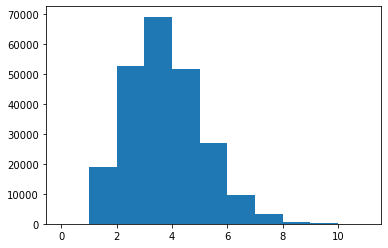

In [88]:
plt.hist(af_condition_result['cha2ds2_vasc'], bins=range(0, 12))

## Obtain Cohort Statistics

In [89]:
af_condition_result.groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,load_table_id,gender_concept_id,birth_DATETIME,age_years,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,33927,33927,33927,33927,33927,2120,2120,33927,0,23458,...,33927,33927,33927,33927,33927,33927,33927,33927,33927,33927
8516,7323,7323,7323,7323,7323,523,523,7323,0,5625,...,7323,7323,7323,7323,7323,7323,7323,7323,7323,7323
8527,176278,176278,176278,176278,176278,12018,12018,176278,0,125213,...,176278,176278,176278,176278,176278,176278,176278,176278,176278,176278
8557,1462,1462,1462,1462,1462,100,100,1462,0,989,...,1462,1462,1462,1462,1462,1462,1462,1462,1462,1462
8657,561,561,561,561,561,42,42,561,0,414,...,561,561,561,561,561,561,561,561,561,561
38003563,13578,13578,13578,13578,13578,996,996,13578,0,9225,...,13578,13578,13578,13578,13578,13578,13578,13578,13578,13578


In [90]:
af_condition_result.groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,load_table_id,birth_DATETIME,race_concept_id,age_years,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,129621,129621,129621,129621,129621,8475,8475,129621,0,91223,...,129621,129621,129621,129621,129621,129621,129621,129621,129621,129621
8532,103508,103508,103508,103508,103508,7324,7324,103508,0,73701,...,103508,103508,103508,103508,103508,103508,103508,103508,103508,103508


In [91]:
af_condition_result['age_years'].describe()

count    233129.000000
mean         77.264433
std           7.799555
min          65.000000
25%          71.000000
50%          77.000000
75%          83.000000
max          95.000000
Name: age_years, dtype: float64

In [92]:
af_condition_result['chf_history'].value_counts()

False    178973
True      54156
Name: chf_history, dtype: int64

In [93]:
af_condition_result['htn_history'].value_counts()

True     152305
False     80824
Name: htn_history, dtype: int64

In [94]:
af_condition_result['dm_history'].value_counts()

False    216422
True      16707
Name: dm_history, dtype: int64

In [95]:
af_condition_result['vascular_history'].value_counts()

False    192772
True      40357
Name: vascular_history, dtype: int64

## Survival Analysis

### Create Survival Table

In [96]:
def stroke_event(person_id, condition_start_DATE):
    time_window = datetime.timedelta(days=1000)
    
    # Did the patient suffer stroke?
    match = stroke_outcome_result.query('person_id == @person_id')
    if not match.empty:
        for _, row in match.iterrows():
            if row['condition_start_DATE'] >= condition_start_DATE and \
               row['condition_start_DATE'] < condition_start_DATE + time_window:
                return pd.Series([row['condition_start_DATE'], None])
            
    # TODO: Check whether the patient died from stroke.
    
    # Patient is censored at the end of the window.
    return pd.Series([None, condition_start_DATE + time_window])
    
af_condition_result[['stroke_DATE', 'censure_DATE']] = af_condition_result.swifter.progress_bar(True).apply(
    lambda row: stroke_event(row['person_id'], row['condition_start_DATE']), axis=1)

Dask Apply:   0%|          | 0/48 [00:00<?, ?it/s]

In [97]:
af_condition_result['T'], af_condition_result['E'] = lifelines.utils.datetimes_to_durations(start_times=af_condition_result['condition_start_DATE'],
                                                                                            end_times=af_condition_result['stroke_DATE'],
                                                                                            fill_date=af_condition_result['censure_DATE'])

In [98]:
af_condition_result.groupby('T').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,age_years,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,E
T,,,,,,,,,,,,,,,,,,,,,
0.0,1403,1403,1403,1403,1403,146,146,1403,0,940,...,1403,1403,1403,1403,1403,1403,1403,1403,0,1403
1.0,227,227,227,227,227,11,11,227,0,123,...,227,227,227,227,227,227,227,227,0,227
2.0,122,122,122,122,122,5,5,122,0,86,...,122,122,122,122,122,122,122,122,0,122
3.0,88,88,88,88,88,3,3,88,0,53,...,88,88,88,88,88,88,88,88,0,88
4.0,66,66,66,66,66,4,4,66,0,48,...,66,66,66,66,66,66,66,66,0,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.0,2,2,2,2,2,0,0,2,0,2,...,2,2,2,2,2,2,2,2,0,2
997.0,2,2,2,2,2,0,0,2,0,2,...,2,2,2,2,2,2,2,2,0,2
998.0,8,8,8,8,8,1,1,8,0,6,...,8,8,8,8,8,8,8,8,0,8


### Study CHA2DS2-VASc Concordance

In [99]:
input_group = None
input_stat_fn = None

def gen_sample_and_get_stat(seed):
    # Obtain a bootstrap sample then apply statistics.
    global input_group
    global input_stat_fn
    return input_stat_fn(input_group.sample(frac=1, replace=True, random_state=seed))
        
# Compute confidence interval using parallel bootstrapping.
def bootstrap_ci(group, stat_fn):
    bootstraps = 1000
    alpha = 95
    chunksize = int(bootstraps / os.cpu_count())
    
    global input_group
    input_group = group
    
    global input_stat_fn
    input_stat_fn = stat_fn

    pool_obj = multiprocessing.Pool()
    
    # Obtain a population of statistics.
    stats = []
    for stat in pool_obj.imap_unordered(gen_sample_and_get_stat, range(bootstraps), chunksize):
        stats.append(stat)
        
    pool_obj.close()
    pool_obj.join()
        
    # Caculate mean.
    mean = np.mean(stats)

    # Calculate confidence interval.
    ordered = np.sort(stats)
    lower = np.percentile(ordered, (100 - alpha) / 2)
    upper = np.percentile(ordered, alpha + ((100 - alpha) / 2))
    
    return (mean, lower, upper)

In [100]:
def compute_concordance(group):
    return lifelines.utils.concordance_index(group['T'], -group['cha2ds2_vasc'], group['E'])

In [101]:
(c, lower, upper) = bootstrap_ci(af_condition_result, compute_concordance)
print("c: {:.2f} (CI: {:.2f}~{:.2f})".format(c, lower, upper))

c: 0.66 (CI: 0.66~0.67)


In [102]:
# Obtain c-statistic for each race group.
for race, group in af_condition_result.groupby('race_concept_id'):
    (c, lower, upper) = bootstrap_ci(group, compute_concordance)
    print("Race: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], c, lower, upper))

Race: Asian, c: 0.65 (CI: 0.63~0.66)
Race: Black, c: 0.69 (CI: 0.65~0.71)
Race: White, c: 0.66 (CI: 0.66~0.67)
Race: Pacific Islander, c: 0.46 (CI: 0.32~0.62)
Race: Native American, c: 0.84 (CI: 0.75~0.93)
Race: Hispanic, c: 0.73 (CI: 0.70~0.76)


In [103]:
# Obtain c-statistic for each gender.
for gender, group in af_condition_result.groupby('gender_concept_id'):
    (c, lower, upper) = bootstrap_ci(group, compute_concordance)
    print("Race: {}, c: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], c, lower, upper))

Race: Male, c: 0.65 (CI: 0.64~0.65)
Race: Female, c: 0.69 (CI: 0.68~0.70)


### Observe Negative Events

In [104]:
def calibration(group):
    total = len(group)
    event = len(group[group['E'] == True])
    return event / total * 100

Observe calibration across race.

In [105]:
race_calibration = []

for cutoff in range(1, 8):
    print("Cutoff: {}".format(cutoff))
    for race, group in af_condition_result[af_condition_result['cha2ds2_vasc'] == cutoff].groupby('race_concept_id'):
        (ratio, lower, upper) = bootstrap_ci(group, calibration)
        race_calibration.append([cutoff, race, ratio, lower, upper])

Cutoff: 1
Cutoff: 2
Cutoff: 3
Cutoff: 4
Cutoff: 5
Cutoff: 6
Cutoff: 7


In [106]:
race_calibration = pd.DataFrame(data=race_calibration,
                                columns=['cha2ds2_vasc', 'race_concept_id', 'calibration', 'lower', 'upper'])
race_calibration

,cha2ds2_vasc,race_concept_id,calibration,lower,upper
0,1,8515,2.275569,1.697186,2.903082
1,1,8516,2.266879,0.636943,4.140127
2,1,8527,2.213916,2.006452,2.438710
3,1,8557,0.000000,0.000000,0.000000
4,1,8657,0.000000,0.000000,0.000000
5,1,38003563,3.353457,2.127660,4.654255
6,2,8515,2.251967,1.894918,2.598694
7,2,8516,1.297128,0.696258,1.914708
8,2,8527,2.605529,2.458997,2.758521
9,2,8557,1.104981,0.000000,2.681992


In [107]:
reduced_race_map = {
    8515: 'Asian', 
    8516: 'Black', 
    8527: 'White', 
    38003563: 'Hispanic'
}

Text(0.5, 0, 'CHA2DS2-VASc Score')

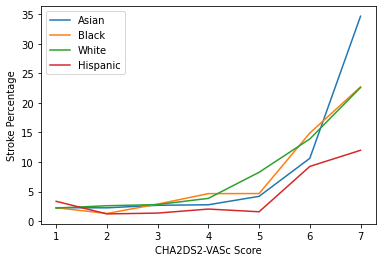

In [108]:
for race, group in race_calibration.groupby('race_concept_id'):
    if race not in reduced_race_map.keys():
        continue
    plt.plot(group['cha2ds2_vasc'], group['calibration'], label=race_map[race])
    
plt.legend(loc='upper left')
plt.ylabel("Stroke Percentage")
plt.xlabel("CHA2DS2-VASc Score")

#### Old Guideline

Under the old guideline, ACC does not recommend antithrombotic therapy for CHA2DS2-VASc scores 1 and below.

In [109]:
no_therapy = af_condition_result[af_condition_result['cha2ds2_vasc'] <= 1]

Observe stratification across race.

In [110]:
for race, group in no_therapy.groupby('race_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Race: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], ratio, lower, upper))

Race: Asian, percentage: 2.28 (CI: 1.70~2.90)
Race: Black, percentage: 2.27 (CI: 0.64~4.14)
Race: White, percentage: 2.21 (CI: 2.01~2.44)
Race: Pacific Islander, percentage: 0.00 (CI: 0.00~0.00)
Race: Native American, percentage: 0.00 (CI: 0.00~0.00)
Race: Hispanic, percentage: 3.35 (CI: 2.13~4.65)


Observe stratification across gender.

In [111]:
for gender, group in no_therapy.groupby('gender_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Gender: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], ratio, lower, upper))

Gender: Male, percentage: 2.25 (CI: 2.04~2.44)


Obtain raw negative event counts.

In [112]:
no_therapy.groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,2239,2239,2239,2239,2239,247,247,2239,0,1439,...,2239,2239,2239,2239,2239,2239,51,2188,2239,2239
8516,314,314,314,314,314,44,44,314,0,222,...,314,314,314,314,314,314,7,307,314,314
8527,15500,15500,15500,15500,15500,1605,1605,15500,0,10087,...,15500,15500,15500,15500,15500,15500,343,15157,15500,15500
8557,69,69,69,69,69,10,10,69,0,32,...,69,69,69,69,69,69,0,69,69,69
8657,45,45,45,45,45,3,3,45,0,30,...,45,45,45,45,45,45,0,45,45,45
38003563,752,752,752,752,752,101,101,752,0,482,...,752,752,752,752,752,752,25,727,752,752


In [113]:
no_therapy.groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,18919,18919,18919,18919,18919,2010,2010,18919,0,12292,...,18919,18919,18919,18919,18919,18919,426,18493,18919,18919


In [114]:
no_therapy[no_therapy['E'] == True].groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,51,51,51,51,51,6,6,51,0,33,...,51,51,51,51,51,51,51,0,51,51
8516,7,7,7,7,7,1,1,7,0,5,...,7,7,7,7,7,7,7,0,7,7
8527,343,343,343,343,343,35,35,343,0,211,...,343,343,343,343,343,343,343,0,343,343
38003563,25,25,25,25,25,3,3,25,0,15,...,25,25,25,25,25,25,25,0,25,25


In [115]:
no_therapy[no_therapy['E'] == True].groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,426,426,426,426,426,45,45,426,0,264,...,426,426,426,426,426,426,426,0,426,426


#### New Guideline

Under the new guideline, ACC does not recommend antithrombotic therapy for CHA2DS2-VASc scores 1 and below for males, scores 2 and below for females.

In [116]:
no_therapy = af_condition_result[
    ((af_condition_result['gender_concept_id'] == 8507) & (af_condition_result['cha2ds2_vasc'] <= 1)) |
    ((af_condition_result['gender_concept_id'] == 8532) & (af_condition_result['cha2ds2_vasc'] <= 2))]

In [117]:
no_therapy[['gender_concept_id', 'cha2ds2_vasc']]

,gender_concept_id,cha2ds2_vasc
16,8507,1
27,8507,1
29,8532,2
51,8532,2
52,8507,1
...,...,...
505582,8507,1
505617,8507,1
505629,8507,1
505640,8507,1


Observe stratification across race.

In [118]:
for race, group in no_therapy.groupby('race_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Race: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(race_map[race], ratio, lower, upper))

Race: Asian, percentage: 2.17 (CI: 1.70~2.67)
Race: Black, percentage: 2.24 (CI: 1.20~3.61)
Race: White, percentage: 2.14 (CI: 1.95~2.32)
Race: Pacific Islander, percentage: 0.00 (CI: 0.00~0.00)
Race: Native American, percentage: 2.00 (CI: 0.00~5.10)
Race: Hispanic, percentage: 1.84 (CI: 1.17~2.47)


Observe stratification across gender.

In [119]:
for gender, group in no_therapy.groupby('gender_concept_id'):
    (ratio, lower, upper) = bootstrap_ci(group, calibration)
    print("Gender: {}, percentage: {:.2f} (CI: {:.2f}~{:.2f})".format(gender_map[gender], ratio, lower, upper))

Gender: Male, percentage: 2.25 (CI: 2.04~2.44)
Gender: Female, percentage: 1.92 (CI: 1.68~2.16)


Obtain raw negative event counts.

In [120]:
no_therapy.groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,3930,3930,3930,3930,3930,440,440,3930,0,2474,...,3930,3930,3930,3930,3930,3930,85,3845,3930,3930
8516,582,582,582,582,582,93,93,582,0,392,...,582,582,582,582,582,582,13,569,582,582
8527,25124,25124,25124,25124,25124,2613,2613,25124,0,16428,...,25124,25124,25124,25124,25124,25124,537,24587,25124,25124
8557,151,151,151,151,151,18,18,151,0,74,...,151,151,151,151,151,151,0,151,151,151
8657,98,98,98,98,98,9,9,98,0,71,...,98,98,98,98,98,98,2,96,98,98
38003563,1539,1539,1539,1539,1539,185,185,1539,0,1003,...,1539,1539,1539,1539,1539,1539,28,1511,1539,1539


In [121]:
no_therapy.groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,18919,18919,18919,18919,18919,2010,2010,18919,0,12292,...,18919,18919,18919,18919,18919,18919,426,18493,18919,18919
8532,12505,12505,12505,12505,12505,1348,1348,12505,0,8150,...,12505,12505,12505,12505,12505,12505,239,12266,12505,12505


In [122]:
no_therapy[no_therapy['E'] == True].groupby('race_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
race_concept_id,,,,,,,,,,,,,,,,,,,,,
8515,85,85,85,85,85,9,9,85,0,49,...,85,85,85,85,85,85,85,0,85,85
8516,13,13,13,13,13,1,1,13,0,9,...,13,13,13,13,13,13,13,0,13,13
8527,537,537,537,537,537,51,51,537,0,340,...,537,537,537,537,537,537,537,0,537,537
8657,2,2,2,2,2,0,0,2,0,1,...,2,2,2,2,2,2,2,0,2,2
38003563,28,28,28,28,28,3,3,28,0,17,...,28,28,28,28,28,28,28,0,28,28


In [123]:
no_therapy[no_therapy['E'] == True].groupby('gender_concept_id').count()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,...,chf_history,htn_history,dm_history,stroke_history,vascular_history,cha2ds2_vasc,stroke_DATE,censure_DATE,T,E
gender_concept_id,,,,,,,,,,,,,,,,,,,,,
8507,426,426,426,426,426,45,45,426,0,264,...,426,426,426,426,426,426,426,0,426,426
8532,239,239,239,239,239,19,19,239,0,152,...,239,239,239,239,239,239,239,0,239,239


## Logistic Regression

Conduct logistic regression on primary outcome using race, sex, and other covariates.

First encode categorical variables.

In [124]:
# One-hot encode race_concept_id.
race_concept_id = pd.get_dummies(af_condition_result['race_concept_id'], drop_first=True)
race_concept_id = race_concept_id.rename(columns=race_map)

In [125]:
# One-hot encode gender_concept_id.
gender_concept_id = pd.get_dummies(af_condition_result['gender_concept_id'], drop_first=True)
gender_concept_id = gender_concept_id.rename(columns=gender_map)

In [126]:
chf_history = af_condition_result['chf_history'].astype(int)
htn_history = af_condition_result['htn_history'].astype(int)
dm_history = af_condition_result['dm_history'].astype(int)
stroke_history = af_condition_result['stroke_history'].astype(int)
vascular_history = af_condition_result['vascular_history'].astype(int)

Scale numeric variables.

In [127]:
age_years = StandardScaler().fit_transform(af_condition_result['age_years'].to_numpy().reshape(-1, 1))
age_years = pd.DataFrame(age_years.flatten(), columns=['age_years'])
age_years = age_years.set_index(af_condition_result['age_years'].index)

In [128]:
X = pd.concat([race_concept_id, gender_concept_id, chf_history, htn_history, dm_history, stroke_history, vascular_history, age_years], axis=1)
y = af_condition_result['E'].astype(int)

Reserve 80% of the samples for training, the rest for testing.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [130]:
model = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga')
model.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

Verify model accuracy.

In [131]:
model.score(X_test, y_test)

0.9587998112641015

Observe coefficients.

In [132]:
importance = model.coef_.flatten()
importance

array([ 0.26482534,  0.15752019, -1.14585433,  0.3301597 , -0.03750065,
        0.02428677, -0.26601691, -0.25889401,  0.12412901,  3.02091364,
       -0.01166259,  0.11407612])

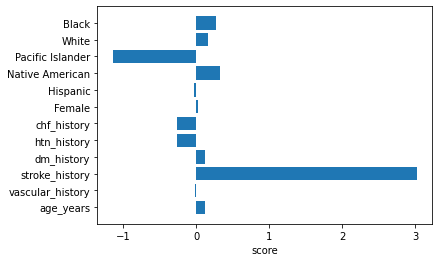

In [133]:
plt.barh(X.columns, importance)
plt.xlabel("score")
plt.gca().invert_yaxis()

In [134]:
model.intercept_

array([-3.60904408])